In [1]:
## Importing required packages
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage, ToolMessage, BaseMessage
from typing import TypedDict, Annotated, Literal

from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace
from langchain_perplexity import ChatPerplexity
from dotenv import load_dotenv

from pydantic import BaseModel, Field
from langgraph.graph import add_messages
import operator

import os
import time

## Libraries to retain memory
from langgraph.checkpoint.memory import InMemorySaver

In [2]:
## Initiating the environment
load_dotenv()

## Defining and initiating llm
model = ChatPerplexity(model= 'sonar', api_key= os.getenv("PERPLEXITY_API_KEY"))

In [3]:
## Defining state
class JokeState(TypedDict):
    topic: str
    joke: str
    explanation: str

In [4]:
## Defining funtions that needs to be executed while invoking graph
def generate_joke(state: JokeState):

    prompt = f'generate a joke on the topic {state["topic"]}'
    response = model.invoke(prompt).content

    return {'joke': response}
def generate_explanation(state: JokeState):

    prompt = f'write an explanation for the joke - {state["joke"]}'
    response = model.invoke(prompt).content

    return {'explanation': response}

In [5]:
## Defining graph
graph = StateGraph(JokeState)

## Add nodes
graph.add_node('generate_joke', generate_joke)
graph.add_node('generate_explanation', generate_explanation)

## Add edges
graph.add_edge(START, 'generate_joke')
graph.add_edge('generate_joke', 'generate_explanation')
graph.add_edge('generate_explanation', END)

## Add check pointers
checkpointer = InMemorySaver()

## Compiling workflow
workflow = graph.compile(checkpointer=checkpointer)

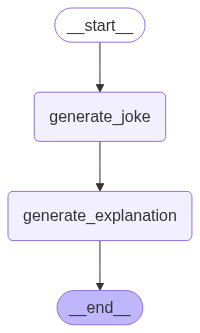

In [6]:
## Visualize the graph
workflow

In [7]:
## Setting up the configuration and invoking the graph
config1 = {"configurable": {"thread_id": "1"}}
initial_state = {'topic' : 'pizza'}
final_state = workflow.invoke(initial_state, config= config1)
print(final_state)

{'topic': 'pizza', 'joke': 'Here\'s a pizza joke for you:\n\n**Why did the pizza go to therapy?**\n\nBecause it was feeling a little crusty!\n\nThis joke plays on the word "crusty," which can refer to both the crust of a pizza and someone feeling grumpy or irritable.', 'explanation': 'The joke "Why did the pizza go to therapy? Because it was feeling a little crusty!" works by playing on the double meaning of the word **"crusty."** \n\n**Crusty** literally refers to the **crust of a pizza**, the outer baked edge that is firm and sometimes crunchy. However, in everyday language, **"crusty"** can also describe a person who is **grumpy, irritable, or emotionally rough**. The humor comes from imagining a pizza—an inanimate object—having feelings and going to therapy because it feels emotionally "crusty," blending the literal and figurative meanings of the word.\n\nThis joke cleverly uses this wordplay to create a light-hearted, relatable connection between food and human emotions, making it

In [8]:
## 1. Checking final state
workflow.get_state(config= config1)

StateSnapshot(values={'topic': 'pizza', 'joke': 'Here\'s a pizza joke for you:\n\n**Why did the pizza go to therapy?**\n\nBecause it was feeling a little crusty!\n\nThis joke plays on the word "crusty," which can refer to both the crust of a pizza and someone feeling grumpy or irritable.', 'explanation': 'The joke "Why did the pizza go to therapy? Because it was feeling a little crusty!" works by playing on the double meaning of the word **"crusty."** \n\n**Crusty** literally refers to the **crust of a pizza**, the outer baked edge that is firm and sometimes crunchy. However, in everyday language, **"crusty"** can also describe a person who is **grumpy, irritable, or emotionally rough**. The humor comes from imagining a pizza—an inanimate object—having feelings and going to therapy because it feels emotionally "crusty," blending the literal and figurative meanings of the word.\n\nThis joke cleverly uses this wordplay to create a light-hearted, relatable connection between food and huma

In [9]:
## 1. Checking partial states
list(workflow.get_state_history(config= config1))

[StateSnapshot(values={'topic': 'pizza', 'joke': 'Here\'s a pizza joke for you:\n\n**Why did the pizza go to therapy?**\n\nBecause it was feeling a little crusty!\n\nThis joke plays on the word "crusty," which can refer to both the crust of a pizza and someone feeling grumpy or irritable.', 'explanation': 'The joke "Why did the pizza go to therapy? Because it was feeling a little crusty!" works by playing on the double meaning of the word **"crusty."** \n\n**Crusty** literally refers to the **crust of a pizza**, the outer baked edge that is firm and sometimes crunchy. However, in everyday language, **"crusty"** can also describe a person who is **grumpy, irritable, or emotionally rough**. The humor comes from imagining a pizza—an inanimate object—having feelings and going to therapy because it feels emotionally "crusty," blending the literal and figurative meanings of the word.\n\nThis joke cleverly uses this wordplay to create a light-hearted, relatable connection between food and hum

Cool, new lets invoke another joke and check the functionality of thread_id in Persistence.

In [10]:
## Setting up the configuration and invoking the graph for another topic
config2 = {"configurable": {"thread_id": "2"}}
initial_state = {'topic' : 'dosa'}
final_state = workflow.invoke(initial_state, config= config2)
print(final_state)

{'topic': 'dosa', 'joke': 'Here is a dosa joke for you:\n\n**Why did the dosai get a perm?**  \nBecause it wanted to be a fancy crepe![1]  \n\nThis joke plays on the similarity between dosai (a type of Indian crepe) and a crepe, adding humor with the idea of the dosa getting a hairstyle like a perm.', 'explanation': 'The joke "Why did the dosai get a perm? Because it wanted to be a fancy crepe!" plays on the double meaning of the word "crepe." \n\nA **dosai (or dosa)** is a type of thin, savory Indian crepe made from fermented rice and lentil batter, known for its crispy and slightly spongy texture[1][4]. The word "crepe" here refers to the food item, a thin pancake-like dish.\n\nThe humor arises because "perm" is a hairstyle that makes hair curly or wavy, often considered a "fancy" or stylized look. By saying the dosai got a perm, the joke imagines the dosa as if it were a person wanting to change its appearance to become a "fancy crepe," playing on the idea of both types of crepes (f

In [11]:
## 1. Checking final state thread_id 2
workflow.get_state(config= config2)

StateSnapshot(values={'topic': 'dosa', 'joke': 'Here is a dosa joke for you:\n\n**Why did the dosai get a perm?**  \nBecause it wanted to be a fancy crepe![1]  \n\nThis joke plays on the similarity between dosai (a type of Indian crepe) and a crepe, adding humor with the idea of the dosa getting a hairstyle like a perm.', 'explanation': 'The joke "Why did the dosai get a perm? Because it wanted to be a fancy crepe!" plays on the double meaning of the word "crepe." \n\nA **dosai (or dosa)** is a type of thin, savory Indian crepe made from fermented rice and lentil batter, known for its crispy and slightly spongy texture[1][4]. The word "crepe" here refers to the food item, a thin pancake-like dish.\n\nThe humor arises because "perm" is a hairstyle that makes hair curly or wavy, often considered a "fancy" or stylized look. By saying the dosai got a perm, the joke imagines the dosa as if it were a person wanting to change its appearance to become a "fancy crepe," playing on the idea of bo

In [12]:
## 1. Checking partial states of thread_id 2
list(workflow.get_state_history(config= config2))

[StateSnapshot(values={'topic': 'dosa', 'joke': 'Here is a dosa joke for you:\n\n**Why did the dosai get a perm?**  \nBecause it wanted to be a fancy crepe![1]  \n\nThis joke plays on the similarity between dosai (a type of Indian crepe) and a crepe, adding humor with the idea of the dosa getting a hairstyle like a perm.', 'explanation': 'The joke "Why did the dosai get a perm? Because it wanted to be a fancy crepe!" plays on the double meaning of the word "crepe." \n\nA **dosai (or dosa)** is a type of thin, savory Indian crepe made from fermented rice and lentil batter, known for its crispy and slightly spongy texture[1][4]. The word "crepe" here refers to the food item, a thin pancake-like dish.\n\nThe humor arises because "perm" is a hairstyle that makes hair curly or wavy, often considered a "fancy" or stylized look. By saying the dosai got a perm, the joke imagines the dosa as if it were a person wanting to change its appearance to become a "fancy crepe," playing on the idea of b

#### Time Travel

In [15]:
workflow.get_state({"configurable": {"thread_id": "2", "checkpoint_id": "1f081254-81f7-6ecd-8000-c23798cddea7"}})

StateSnapshot(values={'topic': 'dosa'}, next=('generate_joke',), config={'configurable': {'thread_id': '2', 'checkpoint_id': '1f081254-81f7-6ecd-8000-c23798cddea7'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2025-08-24T20:02:37.228206+00:00', parent_config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f081254-81db-65ea-bfff-511b5607c4f0'}}, tasks=(PregelTask(id='1fd70fe4-bab7-bdb9-77d1-bef927ffd52c', name='generate_joke', path=('__pregel_pull', 'generate_joke'), error=None, interrupts=(), state=None, result={'joke': 'Here is a dosa joke for you:\n\n**Why did the dosai get a perm?**  \nBecause it wanted to be a fancy crepe![1]  \n\nThis joke plays on the similarity between dosai (a type of Indian crepe) and a crepe, adding humor with the idea of the dosa getting a hairstyle like a perm.'}),), interrupts=())

In [17]:
workflow.invoke(None, {"configurable": {"thread_id": "2", "checkpoint_id": "1f081254-81f7-6ecd-8000-c23798cddea7"}})

{'topic': 'dosa',
 'joke': 'Why did the dosa go to therapy? Because it couldn’t stop flipping out![1]  \n\nOr another one: Why did the dosai get a perm? Because it wanted to be a fancy crepe![1]  \n\nThese jokes play on dosa’s signature thin, crispy, and foldable nature, making light of its cooking style and form.',
 'explanation': 'The jokes play on the unique characteristics of dosa as a thin, foldable, and crispy crepe in Indian cuisine. \n\n1. **"Why did the dosa go to therapy? Because it couldn’t stop flipping out!"**  \nThis joke humorously anthropomorphizes the dosa, referring to the cooking process where the dosa batter is spread thin on a griddle and then "flipped" to cook evenly on both sides. The phrase "flipping out" is a pun here, meaning both the dosa physically flipping on the pan and the common expression for losing control emotionally, hence the dosa needing therapy[1][4].\n\n2. **"Why did the dosai get a perm? Because it wanted to be a fancy crepe!"**  \nThis joke pla

#### Updating State

In [19]:
workflow.update_state({"configurable": {"thread_id": "2", "checkpoint_id": "1f081254-81f7-6ecd-8000-c23798cddea7", "checkpoint_ns": ""}}, {'topic':'samosa'})


{'configurable': {'thread_id': '2',
  'checkpoint_ns': '',
  'checkpoint_id': '1f081258-04df-631d-8001-deccbdcab2f3'}}

In [20]:
list(workflow.get_state_history(config2))

[StateSnapshot(values={'topic': 'samosa'}, next=('generate_joke',), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f081258-04df-631d-8001-deccbdcab2f3'}}, metadata={'source': 'update', 'step': 1, 'parents': {}}, created_at='2025-08-24T20:04:11.485058+00:00', parent_config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f081254-81f7-6ecd-8000-c23798cddea7'}}, tasks=(PregelTask(id='6706008a-47b8-b74f-48a3-23a57274536c', name='generate_joke', path=('__pregel_pull', 'generate_joke'), error=None, interrupts=(), state=None, result=None),), interrupts=()),
 StateSnapshot(values={'topic': 'dosa', 'joke': 'Why did the dosa go to therapy? Because it couldn’t stop flipping out![1]  \n\nOr another one: Why did the dosai get a perm? Because it wanted to be a fancy crepe![1]  \n\nThese jokes play on dosa’s signature thin, crispy, and foldable nature, making light of its cooking style and form.', 'explanation': 'The jokes play on the uni

#### Fault Tolerance

In [47]:
# 1. Define the state
class CrashState(TypedDict):
    input: str
    step1: str
    step2: str

In [ ]:
# 2. Define steps
def step_1(state: CrashState) -> CrashState:
    print("✅ Step 1 executed")
    return {"step1": "done", "input": state["input"]}

def step_2(state: CrashState) -> CrashState:
    print("⏳ Step 2 hanging... now manually interrupt from the notebook toolbar (STOP button)")
    time.sleep(10)  # Simulate long-running hang
    return {"step2": "done"}

def step_3(state: CrashState) -> CrashState:
    print("✅ Step 3 executed")
    return {"done": True}

In [49]:
# 3. Build the graph
builder = StateGraph(CrashState)
builder.add_node("step_1", step_1)
builder.add_node("step_2", step_2)
builder.add_node("step_3", step_3)

builder.set_entry_point("step_1")
builder.add_edge("step_1", "step_2")
builder.add_edge("step_2", "step_3")
builder.add_edge("step_3", END)

checkpointer = InMemorySaver()
graph = builder.compile(checkpointer=checkpointer)

In [ ]:
try:
    print("▶️ Running graph: Please manually interrupt during Step 2...")
    graph.invoke({"input": "start"}, config={"configurable": {"thread_id": 'thread-1'}})
except KeyboardInterrupt:
    print("❌ Kernel manually interrupted (crash simulated).")

▶️ Running graph: Please manually interrupt during Step 2...
✅ Step 1 executed
⏳ Step 2 hanging... now manually interrupt from the notebook toolbar (STOP button)


In [ ]:
# 6. Re-run to show fault-tolerant resume
print("\n🔁 Re-running the graph to demonstrate fault tolerance...")
final_state = graph.invoke(None, config={"configurable": {"thread_id": 'thread-1'}})
print("\n✅ Final State:", final_state)

In [ ]:
list(graph.get_state_history({"configurable": {"thread_id": 'thread-1'}}))